![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 1. BERTicle: News Article Classifier using BERT - Intro

In this project, we develop a news article classifier named **BERTicle** using the BERT (Bidirectional Encoder Representations from Transformers) model. The goal is to classify news articles into one of four categories: **Business**, **Sci/Tech**, **Sports**, and **World**.

We leverage the [AG News Dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which contains over a million news articles collected from a wide variety of news sources. By fine-tuning the pre-trained BERT model, we aim to build an efficient and accurate text classification system that can generalize well to unseen news articles.

This project is divided into two phases:

- **Training:** Fine-tuning the BERT model on the AG News dataset to classify articles into one of the four categories.

- **Deployment:** Building an end-to-end application to serve predictions for new, unseen news articles.

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 2. AG News Dataset Description

The [**AG News dataset**](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a widely used corpus for text classification tasks, especially in the realm of news articles. It consists of over 1 million news articles collected from more than 2000 news sources over the span of one year.

The dataset is organized into the following key fields:

- **Source:** The source of the news article (e.g., CNN, BBC).

- **URL:** The URL link to the news article.

- **Title:** The title of the news article.

- **Image:** An optional field containing the URL to an image associated with the article.

- **Category:** The category of the news article. In our task, we focus on four categories: Business, Sci/Tech, Sports, and World.

- **Description:** A short description or snippet from the article.

- **Rank:** A field indicating the rank of the article (optional).

- **Publication Date:** The timestamp indicating when the article was published.

- **Video:** An optional field containing the URL to a video associated with the article.

This dataset has been frequently **used in research for tasks like clustering, classification, and information retrieval**.

For this project, we are using a **subset** of the AG News dataset, which consists of **120,000 text samples**. Each sample includes two key fields:

- **Title:** The title of the news article, which provides a concise summary of the article's content.

- **Category:** The category to which the news article belongs. In this project, we classify articles into one of four categories: **Business**, **Sci/Tech**, **Sports**, and **World**.

In our project, we will focus on the **classification** task, using the **title** field as input text for training the BERT model to predict the category. This subset has been selected to streamline the classification task while retaining enough data diversity to train an effective model.

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 3. Transformers Overview

Transformers are a very popular architecture that leverage and extend the concept of self-attention to create very useful representations of our input data for a downstream task.

- **Advantages:**
    
    - Better representation for our input tokens via contextual embeddings where the token representation is based on the specific neighboring tokens using self-attention.

    - Sub-word tokens, as opposed to character tokens, since they can hold more meaningful representation for many of our keywords, prefixes, suffixes, etc.

    - Attend (in parallel) to all the tokens in our input, as opposed to being limited by filter spans (CNNs) or memory issues from sequential processing (RNNs).

- **Disadvantages:**
    
    - Computationally intensive
    
    - Requires large amounts of data (mitigated using pretrained models)


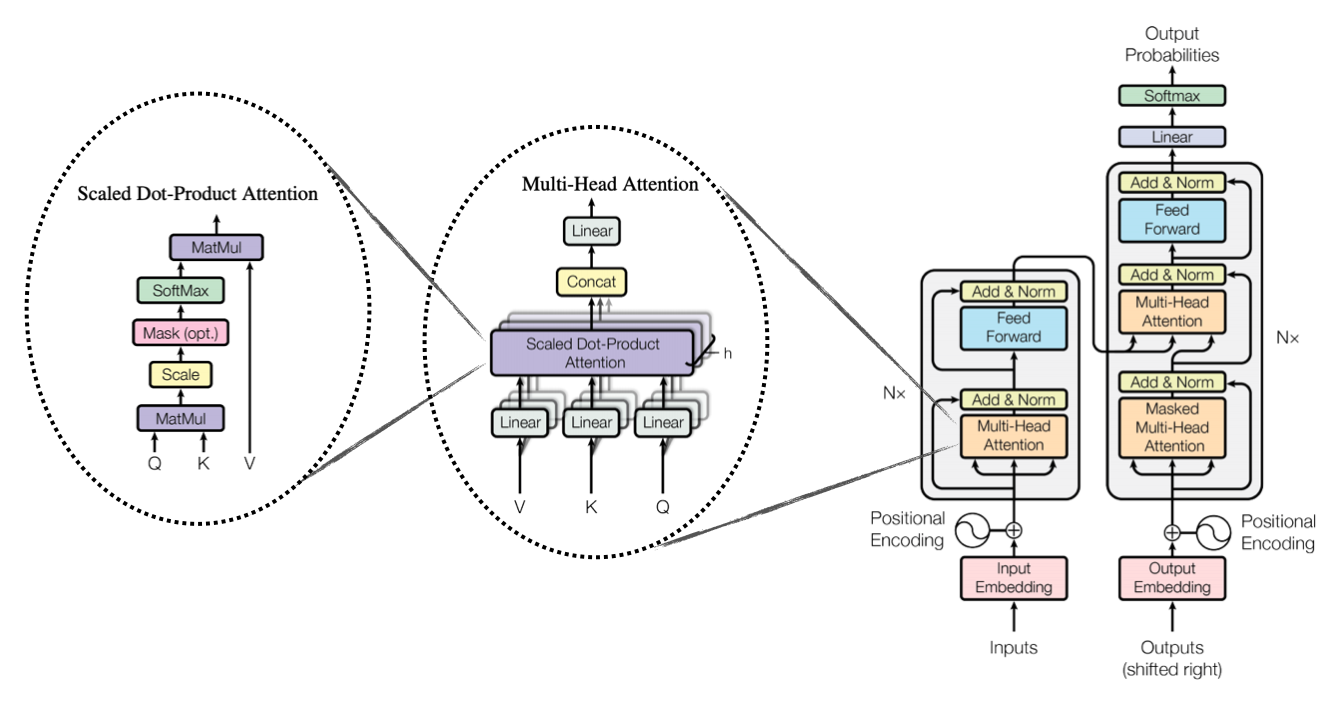

In [46]:
# Transformer Architecture

from IPython import display
display.Image("data/images/NLP_Project_01_BERTicle-02.png")

![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)

# 4. Preparing Data for BERT Training

## Setup Seed and Device

In [47]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [48]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU

In [49]:
SEED = 1234
set_seeds(seed=SEED)

In [50]:
# Set Device
cuda = True
device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print(f"Device: {device}")

Device: cuda


## Load Dataset

In [51]:
dataset_path = "/content/data/datasets/ag_news_dataset.csv"
df = pd.read_csv(dataset_path, header=0)
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


## Preprocessing

We're going to clean up our input data first by doing operations such as lower text, removing stop (filler) words, filters using regular expressions, etc.

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [53]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print(f"Example stopwords: {STOPWORDS[:5]}")
porter = PorterStemmer()

Example stopwords: ['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task"""
    # Convert to Lower Case
    text = text.lower()

    # Remove Stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Handle Spacing and Punctuation
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)  # Inserts spaces around certain punctuation marks
    text = re.sub("[^A-Za-z0-9]+", " ", text) # Remove non-alphanumeric characters
    text = re.sub(" +", " ", text)  # Remove multiple spaces
    text = text.strip()  # Remove any extra spaces at the beginning or end

    return text

In [55]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [56]:
# Apply Preprocessing to the dataframe
preprocessed_df = df.copy()
preprocessed_df["title"] = preprocessed_df["title"].apply(preprocess)
# Print title of first sample from both dataframes
print(f"Original title: {df['title'].values[0]}")
print(f"Preprocessed title: {preprocessed_df['title'].values[0]}")

Original title: Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says
Preprocessed title: sharon accepts plan reduce gaza army operation haaretz says


**Note**

For operations that calculate specific statistics (like scaling or normalization), you need to split the dataset first to prevent information from the test set influencing the model. However, for general transformations like text cleaning that don't involve data-specific learning, they can safely be applied before the dataset is split.

- **Preprocessing with learning** (e.g., standardization, normalization): Must be done **after splitting the data** into training and test sets, to avoid data leakage.

- **Global preprocessing steps** (e.g., text cleaning): **Can be done before splitting** because they do not introduce any data leakage risk.

- **Data leakage:** It occurs when the model gets access to information from the test set (unintentionally or prematurely), which leads to overly optimistic performance and makes the model less reliable when deployed.

## Split Dataset

In [57]:
import collections
from sklearn.model_selection import train_test_split

In [58]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [59]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits"""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [60]:
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [61]:
# Create dataset splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)

print (f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print (f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}")
print (f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train.shape: (84000,), y_train.shape: (84000,)
X_val.shape: (18000,), y_val.shape: (18000,)
X_test.shape: (18000,), y_test.shape: (18000,)
Sample point: china battles north korea nuclear talks → World


## Label Encoding

Next we'll define a `LabelEncoder` to encode our text labels into unique indices.

In [62]:
import itertools

In [63]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            y_one_hot[i][self.class_to_index[item]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            index = np.where(item == 1)[0][0]
            classes.append(self.index_to_class[index])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [64]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [65]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in y_train])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


In [66]:
# Convert labels to tokens
print (f"Original y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"Encoded y_train[0]: {y_train[0]}")
print (f"Decoded y_train[0]: {label_encoder.decode([y_train[0]])}")

Original y_train[0]: World
Encoded y_train[0]: [0 0 0 1]
Decoded y_train[0]: ['World']


## Tokenizer

We'll be using the `BertTokenizer` to tokenize our input text in to sub-word tokens.

In [67]:
from transformers import DistilBertTokenizer
from transformers import BertTokenizer

In [69]:
# Load tokenizer and model
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vocab_size = len(tokenizer)
print (f"Vocab size: {vocab_size}")

Vocab size: 31090


In [70]:
# Tokenize inputs
encoded_input = tokenizer(X_train.tolist(), return_tensors="pt", padding=True)
X_train_ids = encoded_input["input_ids"]
X_train_masks = encoded_input["attention_mask"]
print(f"X_train_ids.shape, X_train_masks.shape = {X_train_ids.shape, X_train_masks.shape}")
encoded_input = tokenizer(X_val.tolist(), return_tensors="pt", padding=True)
X_val_ids = encoded_input["input_ids"]
X_val_masks = encoded_input["attention_mask"]
print(f"X_val_ids.shape, X_val_masks.shape = {X_val_ids.shape, X_val_masks.shape}")
encoded_input = tokenizer(X_test.tolist(), return_tensors="pt", padding=True)
X_test_ids = encoded_input["input_ids"]
X_test_masks = encoded_input["attention_mask"]
print(f"X_test_ids.shape, X_test_masks.shape = {X_test_ids.shape, X_test_masks.shape}")

X_train_ids.shape, X_train_masks.shape = (torch.Size([84000, 29]), torch.Size([84000, 29]))
X_val_ids.shape, X_val_masks.shape = (torch.Size([18000, 27]), torch.Size([18000, 27]))
X_test_ids.shape, X_test_masks.shape = (torch.Size([18000, 28]), torch.Size([18000, 28]))


In [71]:
# Decode
print (f"{X_train_ids[0]}\n{tokenizer.decode(X_train_ids[0])}")

tensor([  102,  3640, 26290, 30113,  4656,  9112,  4097, 12662, 30113,   103,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
[CLS] china battles north korea nuclear talks [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [72]:
# Sub-word tokens
print(tokenizer.convert_ids_to_tokens(ids=X_train_ids[0]))

['[CLS]', 'china', 'battle', '##s', 'north', 'korea', 'nuclear', 'talk', '##s', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


![rainbow](https://github.com/ancilcleetus/My-Learning-Journey/assets/25684256/839c3524-2a1d-4779-85a0-83c562e1e5e5)